%load_ext autoreload
%autoreload 2

In [1]:
import model_funcs
import numpy as np
import sympy as sm
from scipy import interpolate
from bokeh.io import output_notebook,show
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

In the following representation, we have divided the project in six sections. 
1. Introduction to our simple macro model
2. Solving the simple macro model
3. Introduction and solution to the micromodel
4. Solving the modified solowmodel
5. Different methods to solve the model
6. Solving the model for different $\theta$

# 1. Our Model

Our model is the classic solowmodel, but instead of having a fixed savings rate, in each period the savings rate is decided by a micro-household optimization problem. We will get back to this later but first we will solve the simple Solow model with a fixed savingsrate.

**Macro foundations**

The basic solow model consists of the following equations:
$$
Y_t = A K^{\alpha} L^{1-\alpha}
$$$$
K_{t+1}=s_{K}\cdot Y_{t}+\left(1-\delta\right)K_{t}
$$$$
L_{t+1}=\left(1+n\right) L_{t}
$$

By denoting $k_{t},y_{t}=\frac{K_{t}}{L_{t}},\frac{Y_{t}}{L_{t}}$ the following transition equation can be derived:
$$
k_{t+1}= \frac{1}{1+n} \left(s_{Kt}\cdot A k_{t}^{\alpha} + \left(1+\delta\right)k_{t} \right)
$$

# 2. Solving the basic Solow model

For a fixed savings rate we know that basic Solow model has convergenge to steady state (Inada-conditions). Convergence will imply $k_{t+1}=k_{t}=k^{*}$ thus we have from the transtition equation that:
$$
k^{*}= \frac{1}{1+n} \left(s_{Kt}\cdot A {k^{*}}^{\alpha} + \left(1+\delta\right)k^{*} \right)
$$
And can use sympy to derive our steady state capital for a given fixed savings will be:

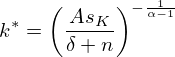

In [2]:
sm.init_printing(use_unicode=True)
# Function that solve the transtion equation
ss_k = model_funcs.steadystate()
ss_k

In [3]:
sm.init_printing(use_unicode=False)

We can also simulate the model with a function defined in model_funcs.py and show it visually.
First we set up reasonable parameter values

$\alpha$, with a Cobb-Douglas production function, this is the incomeshare of capital, it is set to $\frac{1}{3}$, a ordinary macro-assumption. <br>
$\delta$, capital depreciation, is set to $5\%$. <br>
$n$, population growth is set to $0.8\%$ representing average european population growth. <br>
$s_{K}$, the fixed savings rate is set to $20\%$. <br>
$A$ and $L_{0}$ is both normalized to 1. <br>
$K_{0}$ is set to 5, below the steady state. <br>

In [4]:
# Reasonable parameters:
#Macro:
alpha = 1/3
delta = 0.05
n = 0.008
sk = 0.2


# production:
a = 1
k0 = 5
l0 = 1

# Our timeline:
timeline = 200


# Steady state capital pr. worker:
k_star = model_funcs.find_ssk_k(sk,a,delta,n,alpha)
k_stars  =[k_star for i in range(timeline)]

# The evolution of the normal solow model:
trad_k_pr, trad_y_pr = model_funcs.solowwalk(
    k0, a, l0, n, sk, alpha, delta, timeline)

p = model_funcs.plotting("T",['Solow path', 'Steady state'], range(timeline), [trad_k_pr,k_stars],
                    y_name='Capital pr. capita', title = 'Traditional Solowpath',
                    legendlocation ='bottom_center', width = 600)
show(p,notebook_handle=True)

# 3. The micro model

Now that we have seen the solow model with a fixed savingsrate. We will show how the the savingsrate is formed in our micromodel:

**Micro-foundation of the savingsrate** 

Representative household utilityfunction in single periode:
$$
u\left(c_{t}\right)=\frac{c^{1-\theta}-1}{1-\theta}
$$
When the household sums its total utility for mulitiple future periods, it discounts future consumption for immediate consumption by $1-\beta$ so utility for all periods from period 0 to period T, given a vector C of consumption in each period is:
$$
U\left(C\right)=\sum_{t=0}^{T}\beta^{t}\frac{c_{t}^{1-\theta}-1}{1-\theta}
$$
We assume that the household understands how the solow model works, e.i. how production for consumption is made and how capital accumulation works. From the calulations above we have:
$$
y_{t}=A k_{t}^{\alpha} \Rightarrow
c_{t} = \left(1-s_{Kt}\right) A k_{t}^{\alpha}
$$ $$
k_{t+1}= \frac{1}{1+n} \left(s_{Kt}\cdot A k_{t}^{\alpha} + \left(1+\delta\right)k_{t} \right)
$$
This is our 'budget constraint' more precisely defined as production constraints for all periods 

So the final optimizationproblem is:
$$
\max_{s_{K_t}}U\left(C\right)=\sum_{t=0}^{T}\beta^{t}\frac{c_{t}^{1-\theta}-1}{1-\theta}
$$
$$ s.t.$$$$
c_{t} = \left(1-s_{Kt}\right) A k_{t}^{\alpha},\;t\in [0,T]
$$$$
k_{t}=
\begin{cases}
k_{0}& \text{if }t=0\\
\frac{1}{1+n} \left(s_{Kt-1}\cdot A k_{t-1}^{\alpha} + \left(1+\delta\right)k_{t-1} \right)& \text{if }t\in\left[1,T\right]
\end{cases}
$$$$
k_{0} \text{ given}
$$
It's important to note that although the optimization, $s_{Kt}$, is solved for all periods. Only the solution for t=0 is used, since the problem is solved again in the next period. E.g. in each period the household formulates a plan for current and future consumption. In the current period the plan is pursued but in the following period a new plan is formulated, which is then also only followed for one period. 

First we set up microparameter values: <br>
$\theta$, determining the representative household's aversion to fluctations in consumption is as base, set to 0.5, but values below and above are also looked at, as we don't know an approximate of the true value<br>
$\beta$, determining how much the representative households values immediate above future consumption, is set to 0.99. Representing a low preference. <br>
$t$, the amount of future time periods considered by the household, is set to 40 for two reasons: <br>
1. Computational limitations, honestely speed becomes a factor when we simulate a more foresighted representative household. Later we will use other solutionmethod that allows us to relax this assumption.
2. It approximately represents the average remaining lifetime of the working population. As we asumme no 'warm glow' from bequesting, this will also be the timeline that the population cares about on average. 

In [5]:
# Parameters
#Micro:
theta = 0.5
beta = 0.99

t = 40

# time preference utility weights and population growth
# are precomputed to save time:
weight = np.array([beta**i for i in range(t)])
l = np.array([l0*(1+n)**i for i in range(t)])

**Solving the micro-foundation numerically**

First we look at how, for different thetas, optimal savings rate in period t=0, depends on the level of initial capital:

In [6]:
'''We find the prefered savings rate in period t=0
for different thetas an initial capitals'''
k_n = 100
thetas = [0.3,0.5,0.7,1.5]
sks = [np.zeros(k_n) for i in range(len(thetas))]
k0s = np.linspace(0.001,30,k_n)

for j in range(len(thetas)):
    for i in range(k_n):
            sks[j][i] = model_funcs.optimal_sks(
                t, a, l, weight, delta, alpha, thetas[j], k0s[i])
            
# We save the result for theta=0.5 as a interpolater for use in Macro model
sk_interpers = [interpolate.RegularGridInterpolator([k0s], sks[i],
        bounds_error=False,fill_value=None) for i in range(len(thetas))]

In [7]:
''' We use Bokeh to plot and have defined a function in model_funcs.py 
that calls the plot to bokeh ''' 

y_names=[]
# \u03B8 is code for theta 
for theta in thetas:
    y_names.append(f'\u03B8 = {theta:.1f}')

p = model_funcs.plotting("Capital pr. capita",y_names, k0s, sks, width=600)
show(p,notebook_handle=True)

So our models generally implies a negative relationship between amount of capital pr. capita. This makes well intuitive sense, since marginal product of capital is relatively smaller, when there is more of it, and thus the household will choose to consume more now, rather than making a bad investment for future consumption. This also bodes well for our model having convergence, to explain why, first we plot the same graph, but with a line indicating steady state for a given fixed savings rate. To do this we use the below formula derived ealier and plot it for varying $s_{K}$.
$$
k^{*}=\left(\frac{B\cdot s_{K}}{\delta+n}\right)^{\frac{1}{1-\alpha}}
$$


In [8]:
sksopt = model_funcs.find_ssk_sk(k0s,a,delta,n,alpha)

In [9]:
y_names.append('Steady state')
sks.append(sksopt)

In [10]:
figure1 = model_funcs.plotting("Capital pr. capita",y_names, k0s, sks, title='Optimal savings rate for varying \u03B8 and capital pr. capita',width= 600)
show(figure1,notebook_handle=True)

Now we can see that we have convergence. Furthermore we acutaully have faster convergence, than in the traditional solow model. For at fixed savings rate $k_{t}<k^{*}$, the transition equation would imply $\Delta k_{t}>0$. But now, if $k_{t}<k^{*}$ the chosen savings rate by the household will be bigger than at the steady state-level, savings will thus be bigger, implying a bigger $\Delta k_{t}$ when $k_{t} \rightarrow k^{*}$ we will see $s_{Kt} \rightarrow s_{K}^{*}$ and the chosen savings rate will be fixed. <br>
Since we have simple solow model, we know that the real optimal fixed savings rate for maximum overall consumption in the long run is acutally $s_{K}^{**}=\alpha$ which in our case is $\frac{1}{3}$, but we see that this steady state can't be achieved in our model. This is because our representative household is shortsighted and values immediate consumption above future consumption.

**Plotting the consumption plan**

Another way of visually showing convergence is by plotting the consumption plan of the representative houshold. We will do this below. We slightly alter our model when doing this because we now assume that the representative household plans for more periods ahead, e.g. considers and cares about consumption in the next many many periods. Because we now do this we can say that the consummer will stick to the plan made in period 1, in the following period untill it hits steady state where it will stay, since there are no chocks in our model. 

In [11]:
model_funcs.plotting_plan()

Output()

We can see that we hit steady state for almost all parameter values (for large $\theta$s convergence is so slow, that T has to be increased). Thus this way of solving the model is viable.

# 4. The modified solow walk

Now that we have showed in theory that the model will have convergence, we will show it with a simulation of our model, we will look at a timerange of 150 periods and compare how fast this model convergences relative to the traditional solow-model, with a fixed savings rate set at the steady state level savings of our model.

In [12]:
timeline = 150
k0 = 5
'''
This function finds the implied steady state values of s_k and k_t in our model,
basicly by finding the crossing in the above figure.
'''

k_star, sk_star = model_funcs.find_ss_interp(sk_interpers[1], a, n, delta, alpha)


# The evolution of the normal solow model:
trad_k_pr, trad_y_pr = model_funcs.solowwalk(
    k0, a, l0, n, sk_star, alpha, delta, timeline)

# The evolution of the modified solowmodel:
k_pr, y_pr, sk_path = model_funcs.new_mod_solowwalk(
    k0, l0, a,n, alpha, delta, sk_interpers[1], timeline)


In [13]:
# Again plotting with the help of bokeh:
# These are the ones that are shown:
y_names = ['Model path', 'Fixed Savings rate','Steady state level']

ys = [k_pr ,trad_k_pr, [k_star for i in range(timeline)]]

p1 = model_funcs.plotting("T",y_names, range(timeline), ys, 
                     y_name= 'Capital pr. capita',legendlocation ='bottom_center',
                    title = 'Evolution of capital')

ys2 = [sk_path*100, [sk_star*100 for i in range(timeline)]]

p2 = model_funcs.plotting("T",['Model','Steady state/Fixed'], range(timeline), ys2,
                     y_name= 'Savings rate',legendlocation ='top_center',
                    title = 'Evolution of the savings rate',y_unit=' %')

show(row(p1,p2),notebook_handle=True)

Thus we see the faster convergence to the same steady state. we get the same result if our intial $k_{0}>k^{*}$. Lets try with $k_{0}=25$ implying that in the first period, the representative household will actually not want to save any money for the future in the first period.

In [14]:
k0 = 25
# Exactly the same as before
k_star, sk_star = model_funcs.find_ss_interp(sk_interpers[1], a, n, delta, alpha)

trad_k_pr, trad_y_pr = model_funcs.solowwalk(
    k0, a, l0, n, sk_star, alpha, delta,timeline)

k_pr, y_pr, sk_path = model_funcs.new_mod_solowwalk(
    k0, l0, a,n, alpha, delta, sk_interpers[1], timeline)

In [15]:
y_names = ['Model_path', 'Fixed Savings rate','Steady state level']
ys = [k_pr ,trad_k_pr, [k_star for i in range(timeline)]]
p1 = model_funcs.plotting("T",y_names, list(range(timeline)), ys, 
                     y_name= 'Capital pr. capita',legendlocation ='top_center',
                    title='Evolution of capital')
ys2 = [sk_path*100, [sk_star*100 for i in range(timeline)]]
p2 = model_funcs.plotting("T",['Model','Steady state/Fixed'], list(range(timeline)), ys2, 
                     y_name= 'Savings rate', legendlocation ='bottom_center', 
                     title ='Evolution of savings rate',y_unit=' %')
show(row(p1,p2),notebook_handle=True)

# 5. Different ways of solving the model

After initially making this project, Jeppe has explained to us, a faster way of solving this model (And also that the name of the model is actually Ramsey). Here we will solve this model, timing the speed of the the two solutions we have utilized, and also comparing their results.
This new of solving the model actually also requires a slight altering of the assumptions of the model. Instead of assuming that the representative household consideres and values comsumption in a limited time, we assume that this timeframe is, in theory unlimited, but in our model a large enough number of periods to imply convergence (We test 200 periods, if that's not enough we use 400). Going from a considered time frame of 40 to 200 results in a slighter higher savningsrate in steady state, since the household values the future relatively more now.

In [16]:
k0 = 8
theta = 0.5
%load_ext line_profiler

First we look at the time profile for the interpolation solution

In [17]:
def full_solution_interp():
    k_n = 100
    sks = np.zeros(k_n)
    k0s = np.linspace(0.001,30,k_n)


    for i in range(k_n):
        sks[i] = model_funcs.optimal_sks(
            t, a, l, weight, delta, alpha, theta, k0s[i])
            
    # We save these results as a interpolater for use in Macro model
    sk_interper = interpolate.RegularGridInterpolator([k0s], sks,
            bounds_error=False,fill_value=None)

    # We then are able to simulate the model:
    k_star, sk_star = model_funcs.find_ss_interp(sk_interper, a, n, delta, alpha)

    k_pr, y_pr, sk_path = model_funcs.new_mod_solowwalk(
        k0, l0, a,n, alpha, delta, sk_interper, timeline)

def loop(n):
    for i in range(n):
        full_solution_interp()

In [18]:
# This takes about a minut to run
%lprun -f full_solution_interp -f loop loop(10)

Timer unit: 1e-06 s

Total time: 69.9715 s
File: <ipython-input-17-f1b28ac403ea>
Function: full_solution_interp at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def full_solution_interp():
     2        10          9.0      0.9      0.0      k_n = 100
     3        10         47.0      4.7      0.0      sks = np.zeros(k_n)
     4        10        910.0     91.0      0.0      k0s = np.linspace(0.001,30,k_n)
     5                                           
     6                                           
     7      1010       2853.0      2.8      0.0      for i in range(k_n):
     8      1000       2000.0      2.0      0.0          sks[i] = model_funcs.optimal_sks(
     9      1000   69708811.0  69708.8     99.6              t, a, l, weight, delta, alpha, theta, k0s[i])
    10                                                       
    11                                               # We save these resoluts as a

We see that almost all of the computing time for this method is in the setup of this model, e.i. computing the optimal savingsrates for the  interpeter of the capital levels.

In [19]:
def loop_ram(n):
    for i in range(n):
        model_funcs.find_ss_ramsey(
            a, n, beta, delta, alpha, theta, k0=k0,l0=l0,path=True)

In [20]:
%lprun -f model_funcs.find_ss_ramsey -f loop_ram loop_ram(10)

Timer unit: 1e-06 s

Total time: 34.0084 s
File: /Users/Asker/Desktop/OneDrive - Koebenhavns Universitet/Documents/Uni/4. semester/Programering og numerisk analyse /Projects/projects-2019-unity/modelproject/model_funcs.py
Function: find_ss_ramsey at line 363

Line #      Hits         Time  Per Hit   % Time  Line Contents
   363                                           def find_ss_ramsey(a, n, beta, delta, alpha, theta, k0=10,l0=1,path=False):
   364                                              
   365                                               '''
   366                                               Finding the steady state of the model by solving the comsumer optimization
   367                                               once, and finding the point in comsumption plan where savings stabilizes.
   368                                           
   369                                               Args:
   370                                                       a (float)       :

We see that most of the time is still spend calculating the optimal savingrate, but overall a lot less time is needed since the optimizer is now only called once instead of a 100 (albeit it is now optmizing over 200 variables instead of 30). So in conclusion the new solving method is overall faster, but if the interpolater is already calculated (as we did during the visualization of the Micro-problem, interpolation will be faster, since this micro problem is the only part of the problem that takes a notable time to run.<br>
Now we will compare the conclusions of the two different solving methods.

In [21]:
k_star, sk_star = model_funcs.find_ss_interp(sk_interpers[1], a, n, delta, alpha)

k_pr, y_pr, sk_path = model_funcs.new_mod_solowwalk(
    k0, l0, a,n, alpha, delta, sk_interpers[1], timeline)

ss_sk, ss_k, sk_path_2, k_pr_2 = model_funcs.find_ss_ramsey(
    a, n, beta, delta, alpha, theta, k0=k0,l0=l0,path =True)

p1 = model_funcs.plotting("T",['Capital pr. capita','Steady sate'], range(len(k_pr)), 
                          [k_pr,[k_star for i in range(len(k_pr))]], y_name= 'Capital pr. capita',
                          legendlocation ='bottom_center',
                         title = 'Evolution of capital for method 1')

p2 = model_funcs.plotting("T",['Capital pr. capita','Steady sate'], range(len(k_pr_2)), 
                          [k_pr_2,[ss_k for i in range(len(k_pr_2))]], y_name= 'Capital pr. capita',
                          legendlocation ='bottom_center',
                         title = 'Evolution of capital for method 2')

p3 = model_funcs.plotting("T",['Savings rate','Steady state'], range(len(sk_path)), 
                          [sk_path*100,[sk_star*100 for i in range(len(sk_path))]],
                    y_name= 'Savings rate',legendlocation ='top_center',
                    title = 'Evolution of the savings rate for method 1',y_unit=' %')


p4 = model_funcs.plotting("T",['Savings rate','Steady state'], range(len(sk_path_2)), 
                          [sk_path_2*100,[ss_sk*100 for i in range(len(sk_path_2))]],
                    y_name= 'Savings rate',legendlocation ='top_center',
                    title = 'Evolution of the savings rate for method 2',y_unit=' %')

show(column(row(p1,p2),row(p3,p4)),notebook_handle=True)

As expected the second method, with a longer considered timeframe, gives us a slightly higher savingsrate and thus higher capital in the steady state.

# 6. The model for different values of $\theta$

Now we look at the evolution of the model for different values of theta in the household utility function. Both for initially low and initially high $k_{0}$. <br>
Here we use the interpolation method, since the microproblem was solved for different values of $\theta$ earlier in the project.

In [22]:
k_prs_low = []
sk_paths_low = []

k0 = 5
for i in range(4):
    k_pr, y_pr, sk_path = model_funcs.new_mod_solowwalk(
        k0, l0, a,n, alpha, delta, sk_interpers[i], timeline)
    k_prs_low.append(k_pr)
    sk_paths_low.append(sk_path)
    
    

k_prs_high = []
sk_paths_high = []

k0 = 20
for i in range(4):
    k_pr, y_pr, sk_path = model_funcs.new_mod_solowwalk(
        k0, l0, a,n, alpha, delta, sk_interpers[i], timeline)
    k_prs_high.append(k_pr)
    sk_paths_high.append(sk_path)
    

In [23]:
theta_names = ['\u03B8 = 0.3', '\u03B8 = 0.5','\u03B8 = 0.7','\u03B8 = 1.5']

p1 = model_funcs.plotting("T",theta_names, list(range(timeline)), k_prs_low,
                     y_name= 'Capital pr. capita',legendlocation ='bottom_center',
                    title = 'Evolution of the capita pr. capita for different values of \u03B8')

p2 = model_funcs.plotting("T",theta_names, list(range(timeline)), sk_paths_low,
                     y_name= 'Savings rate',legendlocation ='top_center',
                    title = 'Evolution of the savingsrate for different values of \u03B8')


p3 = model_funcs.plotting("T",theta_names, list(range(timeline)), k_prs_high,
                     y_name= 'Capital pr. capita',legendlocation ='top_center',
                    title = 'Evolution of the capita pr. capita for different values of \u03B8')

p4 = model_funcs.plotting("T",theta_names, list(range(timeline)), sk_paths_high,
                     y_name= 'Savings rate',legendlocation ='bottom_center',
                    title = 'Evolution of the savingsrate for different values of \u03B8')


Before we show the figures of the simulation of the macro model, we remind ourselfs of the figure showing the optimal savingsrate for different $\theta$s 
The crossing of the steady state-line with the lines of optimal savings rate, shows our steady state for the given $\theta$. Also it would make sence if the steeper the optimalsavings-line is, the faster the convergence towards the steady state will be. Since the savingsrate will be adjusted more, and the capitalaccumulation will be faster. 

In [24]:
show(figure1,notebook_handle=True)

In [25]:
show(row(p1,p2),notebook_handle=True)
show(row(p3,p4),notebook_handle=True)

Overall we see that a higher $\theta$ gives a slower rate of convergence and a lower steady state level of optimal savingsrate.
And with that we end the project for now, tough the model leaves space for plenty of extensions.